In [1]:
# Defining the environment variables 

import os
import sys
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [2]:
# Importing the SparkSession library

from pyspark.sql import SparkSession


# Creating the SparkSession object

spark = SparkSession.builder \
                    .appName('credit_card')\
                    .getOrCreate()

In [3]:
spark

In [191]:
#reading the credit details file


url1 = "https://s3.amazonaws.com/sqoop.oozie.ml/credit_record.csv"
from pyspark import SparkFiles
spark.sparkContext.addFile(url1)
df_credit = spark.read.csv(SparkFiles.get("credit_record.csv"), header=True, inferSchema= True)

In [192]:
df_credit.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- MONTHS_BALANCE: integer (nullable = true)
 |-- STATUS: string (nullable = true)



# Credit record EDA

In [6]:
df_credit.show(5)

+-------+--------------+------+
|     ID|MONTHS_BALANCE|STATUS|
+-------+--------------+------+
|5001711|             0|     X|
|5001711|            -1|     0|
|5001711|            -2|     0|
|5001711|            -3|     0|
|5001712|             0|     C|
+-------+--------------+------+
only showing top 5 rows



In [7]:
df_credit.count()

1048575

In [25]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


In [9]:
df_status = df_credit.groupBy('STATUS').count().toPandas()
df_status

,STATUS,count
0,3,320
1,0,383120
2,5,1693
3,C,442031
4,X,209230
5,1,11090
6,4,223
7,2,868


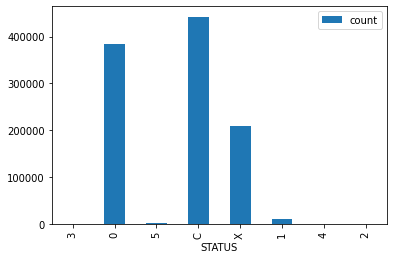

In [10]:
ax = df_status.plot.bar()
ax.set_xlabel('STATUS')
ax.set_xticklabels(df_status.STATUS)
plt.show()

In [193]:
#converting the C X satus to -1

df_credit = df_credit.withColumn("NEW_STATUS", when(df_credit['STATUS'].isin ("C", "X"), -1) .otherwise(df_credit['STATUS']))

df_credit = df_credit.withColumn("Months_delay" ,col("MONTHS_BALANCE") * (-1))
df_credit.show(5)

+-------+--------------+------+----------+------------+
|     ID|MONTHS_BALANCE|STATUS|NEW_STATUS|Months_delay|
+-------+--------------+------+----------+------------+
|5001711|             0|     X|        -1|           0|
|5001711|            -1|     0|         0|           1|
|5001711|            -2|     0|         0|           2|
|5001711|            -3|     0|         0|           3|
|5001712|             0|     C|        -1|           0|
+-------+--------------+------+----------+------------+
only showing top 5 rows



In [194]:
df_credit =df_credit.drop('STATUS',"MONTHS_BALANCE")

In [195]:
df_credit.show(5)

+-------+----------+------------+
|     ID|NEW_STATUS|Months_delay|
+-------+----------+------------+
|5001711|        -1|           0|
|5001711|         0|           1|
|5001711|         0|           2|
|5001711|         0|           3|
|5001712|        -1|           0|
+-------+----------+------------+
only showing top 5 rows



In [196]:
#converting the status to integer type

from pyspark.sql.types import IntegerType
df_credit = df_credit.withColumn("STATUS", df_credit['NEW_STATUS'].cast(IntegerType()))
df_credit.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- NEW_STATUS: string (nullable = true)
 |-- Months_delay: integer (nullable = true)
 |-- STATUS: integer (nullable = true)



In [210]:
df_credit.show(5)

+-------+------------+------+
|     ID|Months_delay|STATUS|
+-------+------------+------+
|5001711|           0|    -1|
|5001711|           1|     0|
|5001711|           2|     0|
|5001711|           3|     0|
|5001712|           0|    -1|
+-------+------------+------+
only showing top 5 rows



In [197]:
df_credit = df_credit.drop('NEW_STATUS')

In [198]:
df_credit.columns

['ID', 'Months_delay', 'STATUS']

In [199]:
df_credit.show()

+-------+------------+------+
|     ID|Months_delay|STATUS|
+-------+------------+------+
|5001711|           0|    -1|
|5001711|           1|     0|
|5001711|           2|     0|
|5001711|           3|     0|
|5001712|           0|    -1|
|5001712|           1|    -1|
|5001712|           2|    -1|
|5001712|           3|    -1|
|5001712|           4|    -1|
|5001712|           5|    -1|
|5001712|           6|    -1|
|5001712|           7|    -1|
|5001712|           8|    -1|
|5001712|           9|     0|
|5001712|          10|     0|
|5001712|          11|     0|
|5001712|          12|     0|
|5001712|          13|     0|
|5001712|          14|     0|
|5001712|          15|     0|
+-------+------------+------+
only showing top 20 rows



In [200]:
df_credit.orderBy(df_credit['STATUS'].desc()).show()

+-------+------------+------+
|     ID|Months_delay|STATUS|
+-------+------------+------+
|5092087|          18|     5|
|5093286|           0|     5|
|5092087|          19|     5|
|5092087|          11|     5|
|5092087|          20|     5|
|5092087|          13|     5|
|5092479|          27|     5|
|5092479|          34|     5|
|5092479|          28|     5|
|5092087|          17|     5|
|5092479|          29|     5|
|5092087|          14|     5|
|5092479|          30|     5|
|5092136|           1|     5|
|5092479|          31|     5|
|5092479|          26|     5|
|5092479|          32|     5|
|5092087|          12|     5|
|5092479|          33|     5|
|5092245|           1|     5|
+-------+------------+------+
only showing top 20 rows



In [28]:
#df_sort = df_credit.orderBy(df_credit['STATUS'].desc())
from pyspark.sql.functions import *


Assuming that a person is consider a defaulter to bank if he has a payment withstanding for more than 60 days. So all the customers having STATUS >= 2 will be considered as defaulters or bad customers

In [212]:
from pyspark.sql.functions import *
#The user ID will be classified as delinquent if the customer has ever delayed by more than 60 days.
#1= bad customer 0 =good
#df_cred = df_sort.withColumn("y", when(df_credit["STATUS"].isin("2", "3" , "4" , "5"), 1 ) .otherwise(0))
df_cred = df_credit.withColumn("y", when(df_credit["STATUS"] >= 2, 1 ) .otherwise(0))


In [213]:
df_cred.groupBy('y').count().show()


+---+-------+
|  y|  count|
+---+-------+
|  1|   3104|
|  0|1045471|
+---+-------+



In [222]:
# sorting the id based months delay so retrieving first row in each id 

from pyspark.sql import Window
from pyspark.sql.functions import rank
window = Window.partitionBy("ID").orderBy("Months_delay")
df = df_cred.withColumn('rank', rank().over(window)).filter(col('rank') == 1).drop('rank')

In [225]:
df.show()

+-------+------------+------+---+
|     ID|Months_delay|STATUS|  y|
+-------+------------+------+---+
|5001812|           0|     0|  0|
|5001849|           0|    -1|  0|
|5001921|           0|    -1|  0|
|5003338|           0|     0|  0|
|5003386|           0|     0|  0|
|5003485|           0|    -1|  0|
|5003623|           0|    -1|  0|
|5004426|           0|    -1|  0|
|5004485|           1|    -1|  0|
|5004511|           0|     0|  0|
|5004620|           0|    -1|  0|
|5004650|           0|    -1|  0|
|5004774|           0|    -1|  0|
|5005000|           0|    -1|  0|
|5005607|           0|    -1|  0|
|5005681|           0|    -1|  0|
|5009033|           0|    -1|  0|
|5009304|           0|    -1|  0|
|5009355|           0|     0|  0|
|5009429|           0|     0|  0|
+-------+------------+------+---+
only showing top 20 rows



In [229]:
df.coalesce(1).write.options(header = True).csv("deliq_cust.csv")

In [5]:
df = spark.read.csv("deliq_cust.csv", header = True, inferSchema = True)

In [6]:
df.count()

45985

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


In [8]:
#readin the application data of the customer

url2 = "https://s3.amazonaws.com/sqoop.oozie.ml/application_record.csv"
from pyspark import SparkFiles
spark.sparkContext.addFile(url2)
df_appln = spark.read.csv(SparkFiles.get("application_record.csv"), header=True, inferSchema= True)

In [7]:
from pyspark.sql.functions import col, countDistinct

df_appln.agg(*(countDistinct(col(c)).alias(c) for c in df_appln.columns)).show()

+------+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|    ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|
+------+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+
|438510|          2|           2|              2|          12|             866|               5|                  5|                 5|                6|     16379|         9406|         1|              2|         2|    

In [176]:
df_appln.select("CODE_GENDER").groupBy("CODE_GENDER").count().show()

+-----------+------+
|CODE_GENDER| count|
+-----------+------+
|          F|294440|
|          M|144117|
+-----------+------+



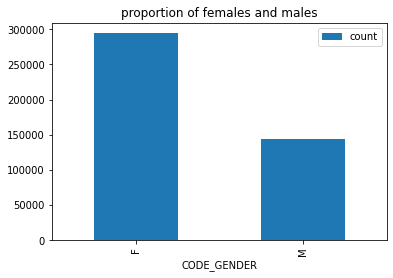

In [177]:
#What is the proportion of females in the applicant customer base?

df_cnt = df_appln.select("CODE_GENDER").groupBy("CODE_GENDER").count().toPandas()
df_cnt.plot.bar(x="CODE_GENDER", y="count", title="proportion of females and males")
plt.show(block=True)

In [22]:
df_appln.select("FLAG_OWN_REALTY","CODE_GENDER").groupBy("FLAG_OWN_REALTY", "CODE_GENDER").count().show()


+---------------+-----------+------+
|FLAG_OWN_REALTY|CODE_GENDER| count|
+---------------+-----------+------+
|              N|          F| 86302|
|              Y|          F|208138|
|              N|          M| 48181|
|              Y|          M| 95936|
+---------------+-----------+------+



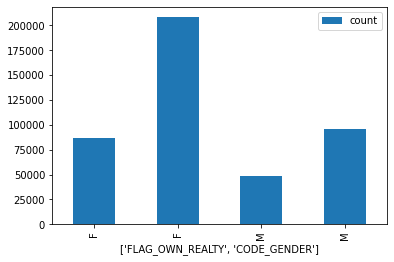

In [20]:
#Is house ownership higher among male applicants or female applicants?
df = df_appln.select("FLAG_OWN_REALTY","CODE_GENDER").groupBy("FLAG_OWN_REALTY", "CODE_GENDER").count().toPandas()
ax = df.plot.bar()
ax.set_xlabel(["FLAG_OWN_REALTY","CODE_GENDER"])
ax.set_xticklabels(df.CODE_GENDER)
plt.show()



In [179]:
#What is the average and median salary of the applicant base?


df_appln.groupBy().mean("AMT_INCOME_TOTAL").show()

+---------------------+
|avg(AMT_INCOME_TOTAL)|
+---------------------+
|    187524.2860095039|
+---------------------+



In [180]:
df_appln.select("AMT_INCOME_TOTAL").summary().show()

+-------+------------------+
|summary|  AMT_INCOME_TOTAL|
+-------+------------------+
|  count|            438557|
|   mean| 187524.2860095039|
| stddev|110086.85306622987|
|    min|           26100.0|
|    25%|          121500.0|
|    50%|          160650.0|
|    75%|          225000.0|
|    max|         6750000.0|
+-------+------------------+



In [181]:
df_appln.select("ID").distinct().count()

438510

In [ ]:
#joining the application data and credit data

In [9]:
df_cdq = df_appln.join(df, df_appln.ID == df.ID, how = "inner").drop(df.ID)

In [10]:
df_cdq.count()

36457

In [10]:
df_cdq.filter("y == 1").show()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+--------------------+---------------+------------+------+---+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|     OCCUPATION_TYPE|CNT_FAM_MEMBERS|Months_delay|STATUS|  y|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+--------------------+---------------+------------+------+---+
|5021430|          F|           N|              Y|           0|        126000.0|Commercial associate|    High

In [230]:
from pyspark.sql.functions import col, countDistinct

df_cdq.agg(*(countDistinct(col(c)).alias(c) for c in df_cdq.columns)).show()

+-----+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+
|   ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|Months_delay|STATUS|  y|
+-----+-----------+------------+---------------+------------+----------------+----------------+-------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+
|36457|          2|           2|              2|           9|             265|               5|                  5|                 5|                6

In [231]:
df_cdq.select("AMT_INCOME_TOTAL","DAYS_BIRTH","DAYS_EMPLOYED", "CNT_FAM_MEMBERS", "CNT_CHILDREN").summary().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|  AMT_INCOME_TOTAL|        DAYS_BIRTH|     DAYS_EMPLOYED|   CNT_FAM_MEMBERS|       CNT_CHILDREN|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|             36457|             36457|             36457|             36457|              36457|
|   mean|186685.73666236937|-15975.17338234084|59262.935567929344| 2.198452971994404|0.43031516581177826|
| stddev|101789.22648234623| 4200.549943759223| 137651.3348588564|0.9116861437101031| 0.7423669007186855|
|    min|           27000.0|            -25152|            -15713|               1.0|                  0|
|    25%|          121500.0|            -19435|             -3153|               2.0|                  0|
|    50%|          157500.0|            -15563|             -1552|               2.0|                  0|
|    75%|          225000.0|            -12463

In [48]:
df_cdq.groupBy('Months_delay').count().show()

+------------+-----+
|Months_delay|count|
+------------+-----+
|          31|  184|
|          53|   26|
|          34|  134|
|          28|  179|
|          26|  199|
|          27|  192|
|          44|   85|
|          12|  417|
|          22|  260|
|          47|   67|
|           1|  606|
|          52|   32|
|          13|  333|
|           6|  390|
|          16|  318|
|           3|  416|
|          40|  103|
|          20|  266|
|          57|   10|
|          54|   23|
+------------+-----+
only showing top 20 rows



In [115]:
df_cdq.filter("DAYS_EMPLOYED == 365243").count()

6248

In [13]:
df_cdq.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- Months_delay: integer (nullable = true)
 |-- STATUS: integer (nullable = true)
 |-- y: integer (nullable = true)



In [17]:
df_cdq.groupBy('FLAG_MOBIL').count().show()

+----------+-----+
|FLAG_MOBIL|count|
+----------+-----+
|         1|36457|
+----------+-----+



In [11]:
dfnew = df_cdq.select("AMT_INCOME_TOTAL" , "NAME_EDUCATION_TYPE")

In [12]:
dfnewP =dfnew.toPandas()

In [15]:
new_df = dfnewP.replace(to_replace=['Higher education', 'Secondary / secondary special','Incomplete higher', 'Lower secondary', 'Academic degree'], value=[1, 2, 3, 4, 5])

In [19]:
#Is there any correlation between income levels and education level?

new_df.corr()


,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE
AMT_INCOME_TOTAL,1.000000,-0.178803
NAME_EDUCATION_TYPE,-0.178803,1.000000


In [40]:
from pyspark.mllib.stat import Statistics
df_cor = df_cdq.toPandas()
df_cor = df_cor.drop("FLAG_MOBIL", axis = 1)
df_cor.corr()
#df_cdq.toPandas().corr()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,Months_delay,STATUS,y
ID,1.000000,0.028878,-0.017667,0.056016,-0.038043,0.079215,0.009879,-0.046979,0.026624,-0.025194,0.015988,0.013473
CNT_CHILDREN,0.028878,1.000000,0.033691,0.339357,-0.229379,0.048091,-0.016291,0.015960,0.889114,0.011469,-0.000987,-0.007283
AMT_INCOME_TOTAL,-0.017667,0.033691,1.000000,0.067908,-0.168611,-0.037746,0.017245,0.086681,0.023750,-0.008727,0.012707,0.009432
DAYS_BIRTH,0.056016,0.339357,0.067908,1.000000,-0.616213,0.179054,-0.028659,0.105625,0.304020,-0.011395,-0.004372,-0.002825
DAYS_EMPLOYED,-0.038043,-0.229379,-0.168611,-0.616213,1.000000,-0.242869,-0.007233,-0.085648,-0.221241,0.006820,-0.002311,-0.002344
FLAG_WORK_PHONE,0.079215,0.048091,-0.037746,0.179054,-0.242869,1.000000,0.311644,-0.034838,0.064527,-0.014203,-0.014446,-0.004761
FLAG_PHONE,0.009879,-0.016291,0.017245,-0.028659,-0.007233,0.311644,1.000000,0.010455,-0.004221,-0.003714,0.000984,0.004190
FLAG_EMAIL,-0.046979,0.015960,0.086681,0.105625,-0.085648,-0.034838,0.010455,1.000000,0.014619,-0.017209,0.021321,0.013351
CNT_FAM_MEMBERS,0.026624,0.889114,0.023750,0.304020,-0.221241,0.064527,-0.004221,0.014619,1.000000,0.009034,-0.002403,-0.007843
Months_delay,-0.025194,0.011469,-0.008727,-0.011395,0.006820,-0.014203,-0.003714,-0.017209,0.009034,1.000000,-0.102507,-0.015705


<AxesSubplot:>

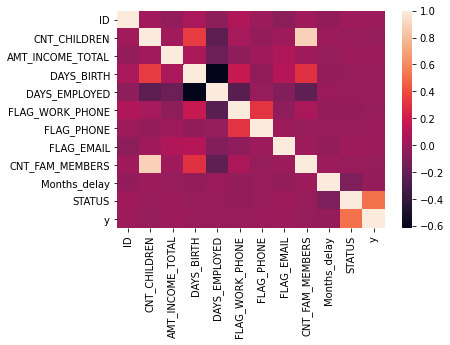

In [44]:
#df1 = df_cdq.toPandas().corr()
sns.heatmap(df_cor.corr())

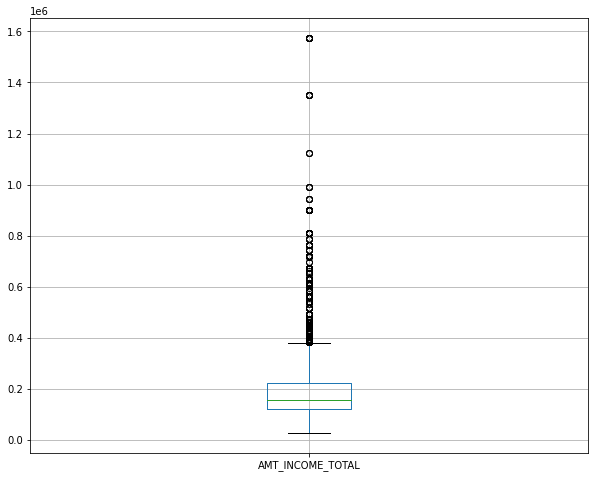

In [254]:
#amount_income_total have outliers 

df = df_cdq.toPandas()
plt.figure(figsize=(10,8))
df.boxplot(column = "AMT_INCOME_TOTAL")
plt.show()

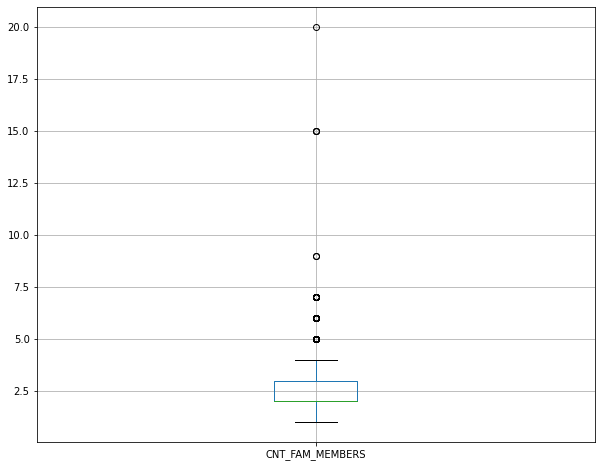

In [255]:
#count of Family Members have outliers 

plt.figure(figsize=(10,8))

df.boxplot(column = "CNT_FAM_MEMBERS")
plt.show()

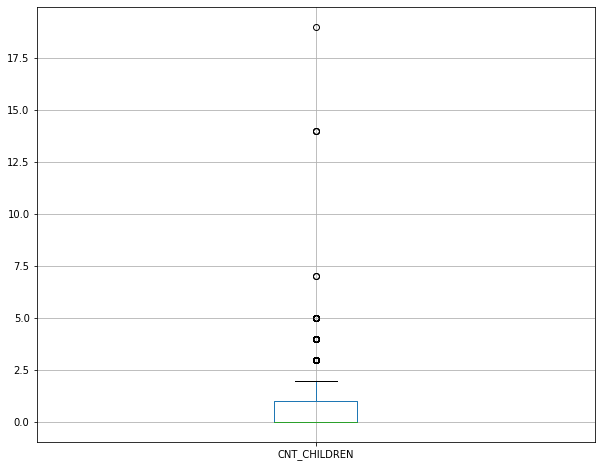

In [256]:
#count of children have outliers 

plt.figure(figsize=(10,8))

df.boxplot(column = "CNT_CHILDREN")
plt.show()

In [42]:
#Is the proportion of bad customers higher for people who own cars?


df_cdq.select("FLAG_OWN_CAR","y").groupBy("FLAG_OWN_CAR", "y").count().show()

+------------+---+-----+
|FLAG_OWN_CAR|  y|count|
+------------+---+-----+
|           N|  1|  392|
|           Y|  1|  224|
|           Y|  0|13843|
|           N|  0|22614|
+------------+---+-----+



In [263]:
import warnings
warnings.filterwarnings('ignore')

In [43]:
df_cdq.show(5)

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|  y|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+---+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    Higher education|      Civil marriage| Rented apartment|    -12005|        -454

In [267]:
#Do people living on rent have a higher proportion of bad customers compared to the rest of the population?

df_cdq.select("NAME_HOUSING_TYPE","y").groupBy("NAME_HOUSING_TYPE", "y").count().show()

+-------------------+---+-----+
|  NAME_HOUSING_TYPE|  y|count|
+-------------------+---+-----+
|Municipal apartment|  1|    4|
|   Office apartment|  0|  262|
|    Co-op apartment|  0|  167|
|       With parents|  0| 1772|
|   Rented apartment|  1|    2|
|  House / apartment|  0|32453|
|    Co-op apartment|  1|    1|
|Municipal apartment|  0| 1124|
|   Rented apartment|  0|  573|
|  House / apartment|  1|   95|
|       With parents|  1|    4|
+-------------------+---+-----+



In [269]:
#Do single customers have a high proportion of bad customers compared to married customers?

df_cdq.select("NAME_FAMILY_STATUS","y").groupBy("NAME_FAMILY_STATUS", "y").count().show()

+--------------------+---+-----+
|  NAME_FAMILY_STATUS|  y|count|
+--------------------+---+-----+
|      Civil marriage|  1|    3|
|               Widow|  0| 1526|
|             Married|  1|   70|
|             Married|  0|24978|
|           Separated|  0| 2097|
|           Separated|  1|    6|
|Single / not married|  1|   21|
|      Civil marriage|  0| 2942|
|               Widow|  1|    6|
|Single / not married|  0| 4808|
+--------------------+---+-----+



In [270]:
#summary of AMT_INCOME_TOTAL|DAYS_BIRTH|DAYS_EMPLOYED|
df_cdq.select("AMT_INCOME_TOTAL","DAYS_BIRTH","DAYS_EMPLOYED").summary("min","50%","75%","90%","95%","96%","97%","99%","100%").show()

+-------+----------------+----------+-------------+
|summary|AMT_INCOME_TOTAL|DAYS_BIRTH|DAYS_EMPLOYED|
+-------+----------------+----------+-------------+
|    min|         27000.0|    -25152|       -15713|
|    50%|        157500.0|    -15563|        -1552|
|    75%|        225000.0|    -12463|         -408|
|    90%|        315000.0|    -10467|       365243|
|    95%|        360000.0|     -9874|       365243|
|    96%|        382500.0|     -9667|       365243|
|    97%|       1575000.0|     -7489|       365243|
|    99%|       1575000.0|     -7489|       365243|
|   100%|       1575000.0|     -7489|       365243|
+-------+----------------+----------+-------------+



In [271]:
df_cdq.count()

36457

In [273]:
#outliers are there in cnt of children 
df_cdq.select("CNT_CHILDREN").summary("99.9%","100%").show()

+-------+------------+
|summary|CNT_CHILDREN|
+-------+------------+
|  99.9%|           4|
|   100%|          19|
+-------+------------+



In [274]:
df_cdq.filter("AMT_INCOME_TOTAL >800000" and "CNT_CHILDREN > 5").count()

6

In [21]:
#since there are outliers from 97% i think we can delete the records becoz 6 records are there

df_cust = df_cdq.filter("AMT_INCOME_TOTAL < 800000" and "CNT_CHILDREN < 5")



In [22]:
df_cust.select("AMT_INCOME_TOTAL","DAYS_BIRTH","DAYS_EMPLOYED").summary("min","50%","75%","90%","95%","96%","100%").show()

+-------+----------------+----------+-------------+
|summary|AMT_INCOME_TOTAL|DAYS_BIRTH|DAYS_EMPLOYED|
+-------+----------------+----------+-------------+
|    min|         27000.0|    -25152|       -15713|
|    50%|        157500.0|    -15565|        -1550|
|    75%|        225000.0|    -12463|         -407|
|    90%|        315000.0|    -10460|       365243|
|    95%|        360000.0|     -9874|       365243|
|    96%|        382500.0|     -9667|       365243|
|   100%|       1575000.0|     -7489|       365243|
+-------+----------------+----------+-------------+



In [23]:
import pyspark.sql.functions as f
#converting days of bith to new column age 

df_cust = df_cust.withColumn("AGE" , f.round(col("DAYS_BIRTH") * (-1)/365,2))


In [277]:
df_cust.show()

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+-----+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|Months_delay|STATUS|  y|  AGE|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+-----+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    H

In [288]:
df_cust.filter((df_cust['DAYS_EMPLOYED'] > 0) & (df_cust['NAME_INCOME_TYPE'] == 'Pensioner')).show()


+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+-----+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|Months_delay|STATUS|  y|  AGE|
+-------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+-----+
|5008812|          F|           N|              Y|           0|        283500.0|       Pensioner|    Higher education|      

In [24]:
# analysing the data in days employed
df_cust.filter((df_cust['DAYS_EMPLOYED'] > 0) & (df_cust['NAME_INCOME_TYPE'] == 'Pensioner')).count()

6135

In [290]:
df_cust.select("DAYS_EMPLOYED").summary().show()

+-------+------------------+
|summary|     DAYS_EMPLOYED|
+-------+------------------+
|  count|             36431|
|   mean| 59307.04391864072|
| stddev|137690.53880208824|
|    min|            -15713|
|    25%|             -3153|
|    50%|             -1547|
|    75%|              -407|
|    max|            365243|
+-------+------------------+



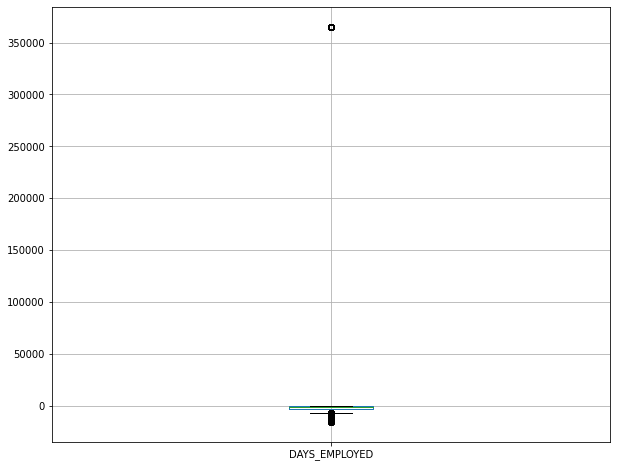

In [291]:
df = df_cust.toPandas()
plt.figure(figsize=(10,8))
df.boxplot(column = "DAYS_EMPLOYED")
plt.show()

In [29]:
#we can handle DAYS_EMPLOYED this outliers using the -1 value since it affect more than 6248 rows
#df_cust = df_cust.withColumn("YEARS_EMPLOY" , f.round(col("DAYS_EMPLOYED") * (-1)/365,2))
df_cust = df_cust.withColumn("YEARS_EMPLOY" , when(df_cust["DAYS_EMPLOYED"] == '365243' , -1)
                                                .otherwise(df_cust["DAYS_EMPLOYED"]))

In [30]:
df_cust.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- FLAG_MOBIL: integer (nullable = true)
 |-- FLAG_WORK_PHONE: integer (nullable = true)
 |-- FLAG_PHONE: integer (nullable = true)
 |-- FLAG_EMAIL: integer (nullable = true)
 |-- OCCUPATION_TYPE: string (nullable = true)
 |-- CNT_FAM_MEMBERS: double (nullable = true)
 |-- Months_delay: integer (nullable = true)
 |-- STATUS: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- AGE: double (nullable = true)
 |-- YEARS_EMPLOY: int

In [31]:
#df_cust[""DAYS_EMPLOYED""].mean().show()
df_cust = df_cust.withColumn("YEARS_EMPLOYED" , f.round(col("YEARS_EMPLOY") * (-1)/365,2))

df_cust.select("YEARS_EMPLOYED").summary().show()

+-------+-----------------+
|summary|   YEARS_EMPLOYED|
+-------+-----------------+
|  count|            36431|
|   mean|6.027697565260264|
| stddev|6.486361215593373|
|    min|              0.0|
|    25%|             1.12|
|    50%|             4.25|
|    75%|             8.64|
|    max|            43.05|
+-------+-----------------+



In [32]:
df_cust.show(5)

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+-----+------------+--------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|DAYS_BIRTH|DAYS_EMPLOYED|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|Months_delay|STATUS|  y|  AGE|YEARS_EMPLOY|YEARS_EMPLOYED|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+-------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+-----+------------+--------------+
|5008804|          M| 

In [33]:
#drop all redundent columns

df_custdata = df_cust.drop("DAYS_BIRTH","DAYS_EMPLOYED","YEARS_EMPLOY")

In [34]:
df_custdata.show(5)

+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+-----+--------------+
|     ID|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS|Months_delay|STATUS|  y|  AGE|YEARS_EMPLOYED|
+-------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-----------------+----------+---------------+----------+----------+---------------+---------------+------------+------+---+-----+--------------+
|5008804|          M|           Y|              Y|           0|        427500.0|             Working|    Higher education|      Civil ma

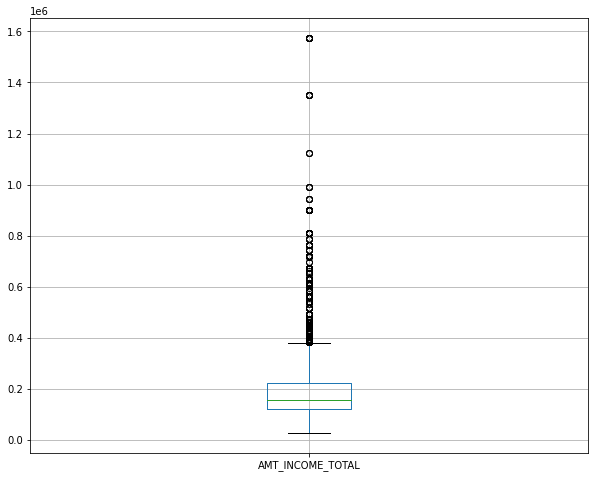

In [298]:
df = df_cust.toPandas()
plt.figure(figsize=(10,8))
df.boxplot(column = "AMT_INCOME_TOTAL")
plt.show()

In [299]:
df_custdata.groupBy("OCCUPATION_TYPE").count().show()

+--------------------+-----+
|     OCCUPATION_TYPE|count|
+--------------------+-----+
|                null|11321|
|            Managers| 3004|
|            HR staff|   85|
|      Medicine staff| 1207|
|         Accountants| 1241|
|            Laborers| 6201|
|      Cleaning staff|  549|
|Private service s...|  344|
|             Drivers| 2135|
|         Sales staff| 3485|
|       Realty agents|   79|
|            IT staff|   60|
|      Security staff|  592|
|         Secretaries|  151|
|  Low-skill Laborers|  175|
|          Core staff| 3591|
|       Cooking staff|  655|
|High skill tech s...| 1383|
|Waiters/barmen staff|  173|
+--------------------+-----+



In [35]:
df_custdata.filter(df_custdata.OCCUPATION_TYPE.isNull()).count()

11321

In [36]:
#coccupation type have blank so renaming to others
df_custdata = df_custdata.withColumn("OCCUPATION_TYPE_NEW" , when(df_custdata.OCCUPATION_TYPE.isNull(), "Others")
                                     .otherwise (df_custdata.OCCUPATION_TYPE))

In [37]:
df_custdata.columns

['ID',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'Months_delay',
 'STATUS',
 'y',
 'AGE',
 'YEARS_EMPLOYED',
 'OCCUPATION_TYPE_NEW']

In [38]:
#dropping OCCUPATION_TYPE
df_custdata = df_custdata.drop("OCCUPATION_TYPE")
df_custdata.groupBy("OCCUPATION_TYPE_NEW").count().show()

+--------------------+-----+
| OCCUPATION_TYPE_NEW|count|
+--------------------+-----+
|            Managers| 3004|
|            HR staff|   85|
|      Medicine staff| 1207|
|         Accountants| 1241|
|            Laborers| 6201|
|      Cleaning staff|  549|
|Private service s...|  344|
|             Drivers| 2135|
|         Sales staff| 3485|
|       Realty agents|   79|
|            IT staff|   60|
|              Others|11321|
|      Security staff|  592|
|         Secretaries|  151|
|  Low-skill Laborers|  175|
|          Core staff| 3591|
|       Cooking staff|  655|
|High skill tech s...| 1383|
|Waiters/barmen staff|  173|
+--------------------+-----+



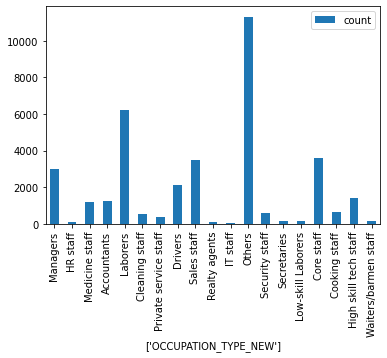

In [39]:
dfE =df_custdata.groupBy("OCCUPATION_TYPE_NEW").count().toPandas()
ax = dfE.plot.bar()
ax.set_xlabel(["OCCUPATION_TYPE_NEW"])
ax.set_xticklabels(dfE.OCCUPATION_TYPE_NEW)
plt.show()

In [304]:
df_custdata.groupBy("NAME_EDUCATION_TYPE").count().show()

+--------------------+-----+
| NAME_EDUCATION_TYPE|count|
+--------------------+-----+
|     Academic degree|   32|
|   Incomplete higher| 1410|
|Secondary / secon...|24751|
|     Lower secondary|  374|
|    Higher education| 9864|
+--------------------+-----+



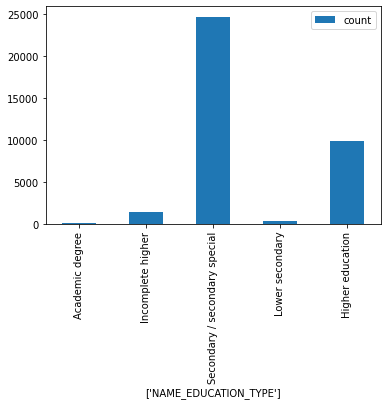

In [308]:
dfE=df_custdata.groupBy("NAME_EDUCATION_TYPE").count().toPandas()
ax = dfE.plot.bar()
ax.set_xlabel(["NAME_EDUCATION_TYPE"])
ax.set_xticklabels(dfE.NAME_EDUCATION_TYPE)
plt.show()



In [94]:
#mydata = df_custdata.select("CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY","CNT_CHILDREN","AMT_INCOME_TOTAL","NAME_INCOME_TYPE","NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE","FLAG_MOBIL","FLAG_WORK_PHONE","FLAG_PHONE","FLAG_EMAIL","OCCUPATION_TYPE","CNT_FAM_MEMBERS","y","AGE","YEARS_EMPLOYED").toPandas()


In [40]:
import pandas as pd
import numpy as np

In [41]:
data = df_custdata.toPandas()

In [42]:
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import warnings
warnings.filterwarnings('ignore')

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [43]:
final_iv_data, IV_data = data_vars(data,data.y)


In [44]:
final_iv_data

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,ID,5008804,5074580,18216,38.0,0.002086,18178.0,0.997914,0.358491,0.500427,-0.333559,0.082838
1,ID,5074581,5150487,18215,68.0,0.003733,18147.0,0.996267,0.641509,0.499573,0.250070,0.082838
2,CODE_GENDER,F,F,24416,61.0,0.002498,24355.0,0.997502,0.575472,0.670475,-0.152796,0.038583
3,CODE_GENDER,M,M,12015,45.0,0.003745,11970.0,0.996255,0.424528,0.329525,0.253326,0.038583
4,FLAG_OWN_CAR,N,N,22601,70.0,0.003097,22531.0,0.996903,0.660377,0.620262,0.062670,0.006993
...,...,...,...,...,...,...,...,...,...,...,...,...
66,OCCUPATION_TYPE_NEW,Realty agents,Realty agents,79,0.0,0.000000,79.0,1.000000,0.000000,0.002175,0.000000,0.212649
67,OCCUPATION_TYPE_NEW,Sales staff,Sales staff,3485,9.0,0.002582,3476.0,0.997418,0.084906,0.095692,-0.119591,0.212649
68,OCCUPATION_TYPE_NEW,Secretaries,Secretaries,151,2.0,0.013245,149.0,0.986755,0.018868,0.004102,1.526023,0.212649
69,OCCUPATION_TYPE_NEW,Security staff,Security staff,592,6.0,0.010135,586.0,0.989865,0.056604,0.016132,1.255262,0.212649


In [45]:
IV_data.sort_values('IV')

,VAR_NAME,IV
18,STATUS,0.000000
6,FLAG_MOBIL,0.000000
8,FLAG_OWN_REALTY,0.000237
1,AMT_INCOME_TOTAL,0.001394
0,AGE,0.003298
3,CNT_FAM_MEMBERS,0.004309
9,FLAG_PHONE,0.005830
7,FLAG_OWN_CAR,0.006993
10,FLAG_WORK_PHONE,0.008343
15,NAME_HOUSING_TYPE,0.008634


In [ ]:
# threshold of 0.002 after you calculate the IV values to eliminate the weak predictors.
#so i am including predictor and eliminating predictors which hold thredshold 0.002

    VAR_NAME	IV
18	STATUS	0.000000
6	FLAG_MOBIL	0.000000
8	FLAG_OWN_REALTY	0.000237
1	AMT_INCOME_TOTAL	0.001394

0	AGE	0.003298
3	CNT_FAM_MEMBERS	0.004309
9	FLAG_PHONE	0.005830
7	FLAG_OWN_CAR	0.006993
10	FLAG_WORK_PHONE	0.008343
15	NAME_HOUSING_TYPE	0.008634
13	NAME_EDUCATION_TYPE	0.017633
19	YEARS_EMPLOYED	0.035115
4	CODE_GENDER	0.038583
2	CNT_CHILDREN	0.046636
5	FLAG_EMAIL	0.046963
11	ID	0.082838
14	NAME_FAMILY_STATUS	0.087367
16	NAME_INCOME_TYPE	0.107992
17	OCCUPATION_TYPE_NEW	0.212649
12	Months_delay	0.212775

In [319]:
df_custdata.columns

['ID',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'Months_delay',
 'STATUS',
 'y',
 'AGE',
 'YEARS_EMPLOYED',
 'OCCUPATION_TYPE_NEW']

In [46]:
df_new = df_custdata.select('AGE','CNT_FAM_MEMBERS','FLAG_PHONE','FLAG_OWN_CAR','FLAG_WORK_PHONE','NAME_HOUSING_TYPE','NAME_EDUCATION_TYPE','YEARS_EMPLOYED','CODE_GENDER','CNT_CHILDREN','FLAG_EMAIL','ID','NAME_FAMILY_STATUS','NAME_INCOME_TYPE','OCCUPATION_TYPE_NEW','Months_delay','y')

In [47]:
df_new.coalesce(1).write.options(header = True).csv("deliq_customer_details_IV.csv")

In [102]:
#df1= spark.read.csv("deliq_customer_details_IV.csv", header = True, inferSchema = True)


In [322]:
df_new.count()

36431

In [ ]:
#df_new.write.options("header","true").csv("s3n://mynithbuck/logistic/deliq_customer_details_IV")
